In [2]:
import os
from glob import glob
from PIL import Image

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
X_train = np.load("../input/256-192-dataset/256_192_train.npy")
y_train = np.load("../input/256-192-dataset/train_labels.npy")
X_val = np.load("../input/256-192-dataset/256_192_val.npy")
y_val = np.load("../input/256-192-dataset/val_labels.npy")

In [4]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [5]:
pre_trained_model = Xception(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

2022-04-02 15:52:21.113431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 15:52:21.229700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 15:52:21.230830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 15:52:21.232564: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

83697664/83683744 [==============================] - 1s 0us/step


In [7]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model.layers))

input_1
block1_conv1
block1_conv1_bn
block1_conv1_act
block1_conv2
block1_conv2_bn
block1_conv2_act
block2_sepconv1
block2_sepconv1_bn
block2_sepconv2_act
block2_sepconv2
block2_sepconv2_bn
conv2d
block2_pool
batch_normalization
add
block3_sepconv1_act
block3_sepconv1
block3_sepconv1_bn
block3_sepconv2_act
block3_sepconv2
block3_sepconv2_bn
conv2d_1
block3_pool
batch_normalization_1
add_1
block4_sepconv1_act
block4_sepconv1
block4_sepconv1_bn
block4_sepconv2_act
block4_sepconv2
block4_sepconv2_bn
conv2d_2
block4_pool
batch_normalization_2
add_2
block5_sepconv1_act
block5_sepconv1
block5_sepconv1_bn
block5_sepconv2_act
block5_sepconv2
block5_sepconv2_bn
block5_sepconv3_act
block5_sepconv3
block5_sepconv3_bn
add_3
block6_sepconv1_act
block6_sepconv1
block6_sepconv1_bn
block6_sepconv2_act
block6_sepconv2
block6_sepconv2_bn
block6_sepconv3_act
block6_sepconv3
block6_sepconv3_bn
add_4
block7_sepconv1_act
block7_sepconv1
block7_sepconv1_bn
block7_sepconv2_act
block7_sepconv2
block7_sepconv2_

In [8]:
last_layer = pre_trained_model.get_layer('block14_sepconv2_act')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 6, 8, 2048)


In [9]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [10]:
train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10)

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [11]:
for layer in pre_trained_model.layers:
    layer.trainable = True

In [12]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 95, 127, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 95, 127, 32)  128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 95, 127, 32)  0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [15]:
batch_size = 64
epochs = 40
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-04-02 15:54:24.714270: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 37748736 exceeds 10% of free system memory.
2022-04-02 15:54:24.871121: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-04-02 15:54:31.110794: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 37748736 exceeds 10% of free system memory.
2022-04-02 15:54:32.042820: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 37748736 exceeds 10% of free system memory.
2022-04-02 15:54:32.171035: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  2/126 [..............................] - ETA: 1:29 - loss: 2.2418 - acc: 0.3125 

2022-04-02 15:54:40.813940: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 37748736 exceeds 10% of free system memory.


  3/126 [..............................] - ETA: 1:47 - loss: 1.9451 - acc: 0.4271

2022-04-02 15:54:41.834245: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 37748736 exceeds 10% of free system memory.


126/126 [==============================] - 152s 1s/step - loss: 0.8981 - acc: 0.7024 - val_loss: 1.1373 - val_acc: 0.6451
Epoch 2/40
126/126 [==============================] - 135s 1s/step - loss: 0.6285 - acc: 0.7736 - val_loss: 0.7392 - val_acc: 0.7254
Epoch 3/40
126/126 [==============================] - 133s 1s/step - loss: 0.5033 - acc: 0.8179 - val_loss: 0.5026 - val_acc: 0.8125
Epoch 4/40
126/126 [==============================] - 135s 1s/step - loss: 0.4208 - acc: 0.8458 - val_loss: 0.4813 - val_acc: 0.8259
Epoch 5/40
126/126 [==============================] - 134s 1s/step - loss: 0.3528 - acc: 0.8698 - val_loss: 0.5120 - val_acc: 0.8013
Epoch 6/40
126/126 [==============================] - 135s 1s/step - loss: 0.3094 - acc: 0.8838 - val_loss: 0.5026 - val_acc: 0.8348
Epoch 7/40
126/126 [==============================] - 134s 1s/step - loss: 0.2680 - acc: 0.9015 - val_loss: 0.3956 - val_acc: 0.8549
Epoch 8/40
126/126 [==============================] - 133s 1s/step - loss: 0.241

In [16]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

29/29 [==============================] - 3s 85ms/step - loss: 0.6685 - acc: 0.8437
Validation: accuracy = 0.843681  ;  loss_v = 0.668486


In [18]:
X_test = np.load("../input/256-192-dataset/256_192_test.npy")
y_test = np.load("../input/256-192-dataset/test_labels.npy")

y_test = to_categorical(y_test)


#test_generator = test_datagen.flow(X_test, y_test)

In [20]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 [==============================] - 3s 84ms/step - loss: 0.7184 - acc: 0.8583
Test: accuracy = 0.858283  ;  loss = 0.718387


In [21]:
model.save("./xception.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [22]:
y_pred=model.predict_generator(X_test)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
K.int_shape(y_pred)

(1002, 7)

In [24]:
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 15   2   9   1   1   0   0]
 [  3  37  11   2   2   0   2]
 [  0   2  87   0  12   0   7]
 [  0   1   1  12   1   0   0]
 [  0   0  21   1 630   1  25]
 [  0   0   1   0   0  13   0]
 [  0   0  18   0  18   0  66]]


In [25]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6']

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.83      0.54      0.65        28
     class 1       0.88      0.65      0.75        57
     class 2       0.59      0.81      0.68       108
     class 3       0.75      0.80      0.77        15
     class 4       0.95      0.93      0.94       678
     class 5       0.93      0.93      0.93        14
     class 6       0.66      0.65      0.65       102

    accuracy                           0.86      1002
   macro avg       0.80      0.76      0.77      1002
weighted avg       0.87      0.86      0.86      1002



dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


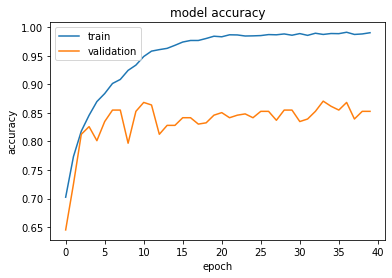

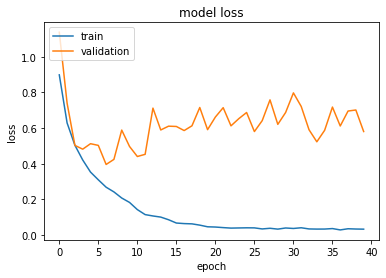

In [27]:
# summarize history for accuracy
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
#plt.plot(history.history['test_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation','test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.plot(history.history['test_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation','test'], loc='upper left')
plt.show()


In [28]:
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
result = sensitivity_specificity_support(y_test,y_pred,average='macro' )

print("Sensitivity: {:5.2f}%".format(100*result[0]), "specificity {:5.2f}%".format(100*result[1]))

Sensitivity: 75.65% specificity 96.79%


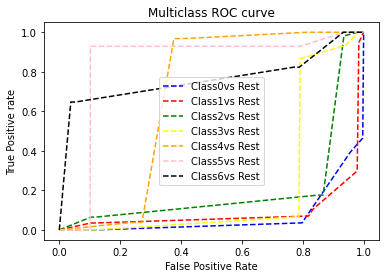

In [29]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 7

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred, pos_label=i)
    
# plotting

colors=['blue','red','green','yellow','orange','pink','black']

for i in range(0,7):
    plt.plot(fpr[i], tpr[i], linestyle='--',color=colors[i], label='Class'+ str(i) +'vs Rest')


plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);